In [1]:
from torch_geometric.explain import Explainer, AttentionExplainer, GNNExplainer

from genericpath import exists

from cell_model import Gatv2Predictor

import torch

import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from cell_dataset import loadDataset

from cell_dataset import cross_val_real

from typing import List, Optional
import pandas as pd

import numpy as np

In [33]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

aggr = "mean"

number_of_messages = 2
size_of_messages = 64
distrib = "normal"
horizon = 4

leave_out = 3

name_complete = "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + distrib + "_h" + str(horizon) + "_leave" + str(leave_out)

path_name = "models/real/" + distrib + "/h" + str(horizon) + "/"

model_path = path_name + "model" + name_complete

data_train, data_test = cross_val_real("data/cell_data/cell_data/", leave_out=leave_out)

Found paths:  ['/mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_18.h5', '/mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_12.h5', '/mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_25.h5', '/mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_72.h5']
Leaving out:  /mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_72.h5
Length:  4


In [34]:
model = Gatv2Predictor(in_channels=8+1+1, out_channels=16, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, horizon=horizon)
    
#Load model  
epoch_to_load = 1600
if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

Loaded model


In [3]:
load_all =  True #load directly from a pickle and bypasses the preprocessing
pre_separated = False #if three subfolders already exist for train test and val
override = False #make this true to always use the same ones

extension = "_open_lt_lv"
number_of_messages = 2
size_of_messages = 256
distrib = "laplace"
out = 8
horizon = 1

aggr = "mean"

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + distrib + "_" + str(out) + "_h" + str(horizon)

path_name = "models/new_model/out_" + str(out) + "_eps_-4/" + distrib + "/" + extension[6:] + "/h" + str(horizon) + "/"

model_path = path_name + "model" + name_complete

data_train, data_test, data_val = loadDataset(load_all, extension, pre_separated, override)


In [4]:
model = Gatv2Predictor(in_channels=13, out_channels=out, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=0, horizon=horizon)

#Load model

epoch_to_load = 50
print("Loading model : ", model_path + str(epoch_to_load) + ".pt")

if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")


Loading model :  models/new_model/out_8_eps_-4/laplace/lt_lv/h1/model_open_lt_lv_2_256_laplace_8_h150.pt
Loaded model


In [35]:
def iterate(data, x, params, masks, model, duration, device, draw, distrib, many_many, explainer):
    out = x[0].detach().clone().unsqueeze(dim=0).to(device)
    
    if masks is not None :
        masks = masks[0]

    _, edge_index, edge_attr = data.get_edges(out[0,:,:2], data.max_degree, wrap=data.wrap, masks=masks)
    
    horizon = model.horizon
    
    gs = []
        
    for current_time in range(0, duration-1) :
        #time embedding
        recent = out[-horizon:].detach().clone().to(device)
        
        time = torch.arange(1, recent.shape[0] + 1, device=device).unsqueeze(1).unsqueeze(2).repeat(1, recent.shape[1], 1).float() / (recent.shape[0] + 1)
        
        input_model = torch.cat((recent, time), dim=2)
        
        with torch.no_grad() :
            output = model(input_model, edge_index.to(device), edge_attr.to(device), params, many_many=many_many)
        
        if draw : 
            values = model.draw(output, distrib=distrib).to(device) + out[current_time,:,:model.out_channels//2]
        else :
            values = output[:,:,:model.out_channels//2] + out[current_time,:,:model.out_channels//2]
            
        explanation = explainer(x=input_model[-1], edge_index=edge_index, edge_attr=edge_attr, params=params)
        assert(explanation.validate() == True)
        
        gs.append(explanation)
        
        returned, edge_index, edge_attr = data.get_edges(values[:,:,:2], data.max_degree, wrap=data.wrap, previous=out[current_time,:,:2], masks=masks)
                
        if model.out_channels == 4 :
            values = returned
        else :
            #add back the degree of the node
            values = torch.cat((values, returned[:,:,-1].unsqueeze(2)), dim=2)
        
        out = torch.cat((out, values), dim=0)
          
    return gs, out[1:duration,:,:2]

In [36]:
#cause they can't make the plot work with the animation
def visualize_feature_importance(
        graphs,
        feat_labels: List[str],
        path: Optional[str] = None,
        top_k: Optional[int] = None,
        ax = None
    ):
        r"""Creates a bar plot of the node feature importances by summing up
        the node mask across all nodes.

        Args:
            path (str, optional): The path to where the plot is saved.
                If set to :obj:`None`, will visualize the plot on-the-fly.
                (default: :obj:`None`)
            feat_labels (List[str], optional): The labels of features.
                (default :obj:`None`)
            top_k (int, optional): Top k features to plot. If :obj:`None`
                plots all features. (default: :obj:`None`)
        """
        
        score = torch.zeros(len(feat_labels))
        
        for graph in graphs:
            node_mask = graph.get('node_mask')
            if node_mask is None:
                raise ValueError(f"The attribute 'node_mask' is not available "
                                f"in '{graph.__class__.__name__}' "
                                f"(got {graph.available_explanations})")
            if node_mask.dim() != 2 or node_mask.size(1) <= 1:
                raise ValueError(f"Cannot compute feature importance for "
                                f"object-level 'node_mask' "
                                f"(got shape {node_mask.size()})")

            if feat_labels is None:
                feat_labels = range(node_mask.size(1))

            score = score + node_mask.sum(dim=0).cpu().numpy()
            
        score = score / len(graphs)
        
        #save the score
        np.save('score' + name_complete + '.npy', score)

        return _visualize_score(score, feat_labels, path, top_k, ax)

def _visualize_score(
    score: torch.Tensor,
    labels: List[str],
    path: Optional[str] = None,
    top_k: Optional[int] = None,
    ax = None
):


    if len(labels) != score.numel():
        raise ValueError(f"The number of labels (got {len(labels)}) must "
                         f"match the number of scores (got {score.numel()})")

    score = score.cpu().numpy()

    df = pd.DataFrame({'score': score}, index=labels)
    df = df.sort_values('score', ascending=False)
    df = df.round(decimals=3)

    if top_k is not None:
        df = df.head(top_k)
        title = f"Feature importance for top {len(df)} features"
    else:
        title = f"Feature importance for {len(df)} features"


    ax = df.plot(
        kind='barh',
        figsize=(10, 7),
        title=title,
        ylabel='Feature label',
        xlim=[0, float(df['score'].max()) + 0.3],
        legend=False,
        ax = ax
    )
    plt.gca().invert_yaxis()
    ax.bar_label(container=ax.containers[0], label_type='edge')


    if path is not None:
        plt.savefig(path)
    #else:
        #plt.show()

    #plt.close()

In [37]:
duration, x, edge_index, edge_attr, masks = data_test.get(0, duration=-1)
params = None

[INFO][2023/08/16 07:05:10 PM] Opening HDF file: /mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_72.h5...
[INFO][2023/08/16 07:05:10 PM] Loading tracks/obj_type_1
[INFO][2023/08/16 07:05:10 PM] Loading objects/obj_type_1 (2527, 5) (2527 filtered: None)
[INFO][2023/08/16 07:05:10 PM] Closing HDF file: /mnt/c/users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_72.h5


Found 81 cells
Found 68 cells without gaps
Found  2007  valid values
Filling rate :  0.5902941176470589


In [6]:
duration, x, edge_index, edge_attr, border, params = data_test.get(0, duration=-1)
masks = None
params = params.to('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
def explainer_explain(title, explainer, model) :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    explainer.algorithm = explainer.algorithm.to(device)
    
    gs, outs = iterate(data_test, x, params, masks, model, duration, device, True, distrib, False, explainer)

    figure, ax = plt.subplots(figsize=(35,10), ncols=3, nrows=1)
    
    #find the edges for node 0 in all the graphs
    edges_node_0_source = []
    edges_node_0_target = []
    for i in range(len(gs)) :
        edges_node_0_source.append(np.where(gs[i].edge_index[0].cpu().numpy() == 0))
        edges_node_0_target.append(np.where(gs[i].edge_index[1].cpu().numpy() == 0))

    #distance along all edges of node 0
    distances = torch.norm(outs[:,edge_index[0]] - outs[:,edge_index[1]], dim=2).cpu().numpy()
    
    #weigths of the edges of node 0
    weigths = np.array([gs[i].edge_mask.cpu().numpy() for i in range(len(gs))])
    
    distances_node_0_source = [distances[i, edges_node_0_source[i]] for i in range(len(gs))]
    weigths_node_0_source = [weigths[i, edges_node_0_source[i]] for i in range(len(gs))]
     
    distances_node_0_target = [distances[i, edges_node_0_target[i]] for i in range(len(gs))]
    weigths_node_0_target = [weigths[i, edges_node_0_target[i]] for i in range(len(gs))]
     
    ax[0].set_xlabel("Distance")
    ax[0].set_ylabel("Weight")
    ax[0].set_title("Distance vs Weight for node 0 as source")
    
    ax[1].set_xlabel("Distance")
    ax[1].set_ylabel("Weight")
    ax[1].set_title("Distance vs Weight for node 0 as target")
    
    ax[2].set_xlabel("Distance")
    ax[2].set_ylabel("Weight")
    ax[2].set_title("Distance vs Weight all nodes")
    
    for i in range(len(gs)) :
        #color is i
        ax[0].scatter(distances_node_0_source[i], weigths_node_0_source[i], color=plt.cm.get_cmap('viridis')(i/len(gs)))
        ax[1].scatter(distances_node_0_target[i], weigths_node_0_target[i], color=plt.cm.get_cmap('viridis')(i/len(gs)))
        ax[2].scatter(distances[i].flatten(), weigths[i].flatten(), color=plt.cm.get_cmap('viridis')(i/len(gs)))
        
    #flatten and do a third degree polynomial fit
    distances_node_0_source = np.concatenate([ np.array(distances_node_0_source[i]).flatten() for i in range(len(gs))])
    weigths_node_0_source = np.concatenate([ np.array(weigths_node_0_source[i]).flatten() for i in range(len(gs))])
     
    distances_node_0_target = np.concatenate([ np.array(distances_node_0_target[i]).flatten() for i in range(len(gs))])
    weigths_node_0_target = np.concatenate([ np.array(weigths_node_0_target[i]).flatten() for i in range(len(gs))])
     
    #source
    z = np.polyfit(distances_node_0_source, weigths_node_0_source, 3)
    p = np.poly1d(z)
    
    xp = np.linspace(0, int(np.max(distances_node_0_source)), 100)
     
    ax[0].plot(xp, p(xp), color="red")
    
    #target
    z = np.polyfit(distances_node_0_target, weigths_node_0_target, 3)
    p = np.poly1d(z)
    
    xp = np.linspace(0, int(np.max(distances_node_0_target)), 100)
    
    ax[1].plot(xp, p(xp), color="red")
    
    #all
    z = np.polyfit(distances.flatten(), weigths.flatten(), 3)
    p = np.poly1d(z)
    
    xp = np.linspace(0, int(np.max(distances.flatten())), 100)
     
    ax[2].plot(xp, p(xp), color="red")
     
    #colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin=0, vmax=len(gs)))
    sm._A = []
    figure.colorbar(sm, ax=ax)
        
    figure.savefig(title + "_distance_vs_weight" + name_complete + ".png")
     
    plt.close(figure)

    #figure, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=1)
    
    def animationFunction(i):

        print("Frame " + str(i) + "/" + str(duration) + " (" + str(i/duration*100) + "%)", end="\r")

        ax.cla()
        
        #draw the graph with the explanation
        exp = gs[i].get_explanation_subgraph()
        g = torch_geometric.utils.to_networkx(exp, to_undirected=False, remove_self_loops=True)
        
        width = gs[i].edge_mask.cpu().numpy()
        nx.draw(G=g, pos=outs[i].cpu().numpy(), with_labels=True, width=width, ax=ax)
 
        return figure,

    #anim = FuncAnimation(figure, animationFunction, frames=duration-1, interval=400, blit=True)

    #anim.save(title + "_animation" + name_complete + ".mp4", writer="ffmpeg")

In [39]:
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("Attention", explainer, model)

In [40]:
def explainer_explain(title, explainer, model) :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    explainer.algorithm = explainer.algorithm.to(device)
    
    gs, outs = iterate(data_test, x, params, masks, model, duration, device, True, distrib, False, explainer)

    features = ["x","y","dx","dy","ori","major","minor","area","degree", "time"]
    
    #features = ["x","y","dx","dy","degree", "time", "tau", "epsilon", "v0", "r", "dt", "max_time", "k"]

    figure, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=1)

    visualize_feature_importance(graphs=gs, feat_labels=features, ax=ax)
    
    plt.title("Mean of feature importances")
    plt.savefig(title + name_complete + ".png")


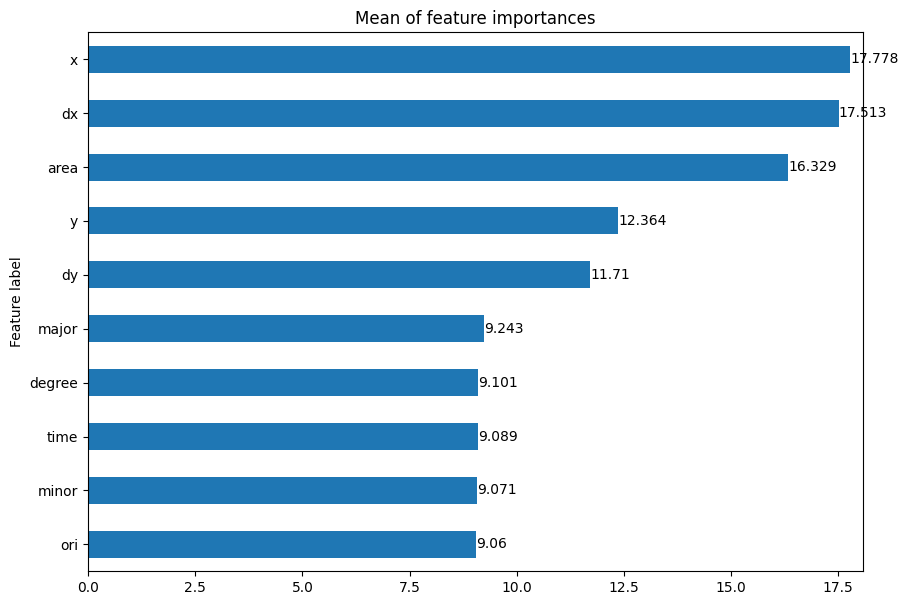

In [41]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("GNN", explainer, model)

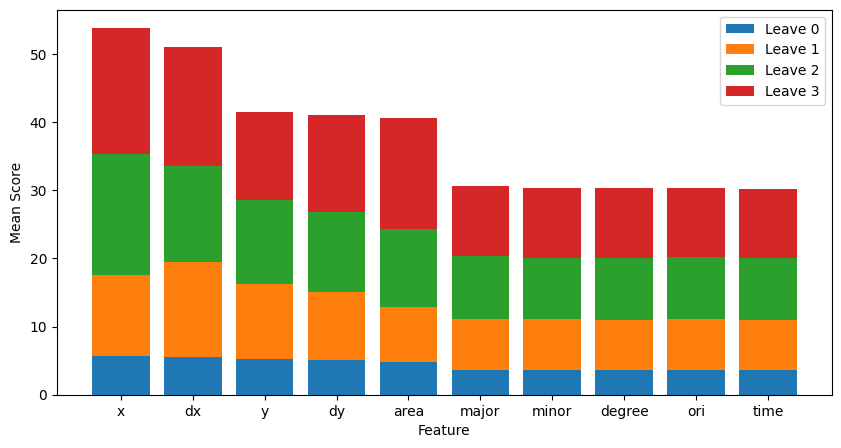

In [42]:
all_scores = []
for i in range(0,4) :
    name_complete = "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + distrib + "_h" + str(horizon) + "_leave" + str(i)
    
    # Load scores
    scores = np.load("score" + name_complete + ".npy")
    all_scores.append(scores)
    
features = ["x","y","dx","dy","ori","major","minor","area","degree", "time"]

# Plot scores in a single cumulative bar plot
fig, ax = plt.subplots(1,1, figsize=(10,5))

#sort the scores and the features
all_scores = np.array(all_scores)
all_scores = np.sort(all_scores, axis=0)
features = np.array(features)[np.argsort(all_scores[0,:])]
all_scores = all_scores[:,np.argsort(all_scores[0,:])]

#reverse the order of the features
features = features[::-1]
all_scores = all_scores[:,::-1]

bottom = None
for i in range(len(all_scores)) :
    ax.bar(np.arange(len(features)), all_scores[i], bottom=bottom, label="Leave " + str(i))
    bottom = all_scores[i] if bottom is None else bottom + all_scores[i]
    
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features)
ax.set_ylabel("Mean Score")
ax.set_xlabel("Feature")
ax.legend()

plt.savefig("scores.png")    